# Forecasting Polish Inflation Rates (November 2022 Update)

Author: **Marcin Sikorski**<br>
Date: November, 2022

Update of univariate time series forecasting. The forecast will be performed by an autoregressive method.

**Data source:** [GUS](https://stat.gov.pl/en/topics/prices-trade/price-indices/harmonized-indices-of-consumer-prices-hicp,15,1.html)

**Notebook Content:**
1. Reading Dataset<br>
2. Stationarizing Series<br>
3. Find Optimal SARIMA Configuration<br>
4. Developing SARIMA Model<br>
5. Conclusion

### 1. Reading Dataset

We will start by loading data from an Excel file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')
import warnings
warnings.filterwarnings('ignore')

# import data
def load_data(file_name):
    # load from XLSX file
    dataset = pd.read_excel(io=file_name)
    
    # unpivot from wide to long format
    dataset = dataset.melt(id_vars='Year', var_name='Month', value_name='Rate')
    
    from pandas.tseries.offsets import MonthEnd
    
    # assign last day of month
    dataset['Date'] = pd.to_datetime(dataset[['Year', 'Month']].assign(DAY=1)) + MonthEnd(1)
    
    # order ascending data values
    dataset = dataset.sort_values(by='Date', ascending=True)
    
    # drop unnecessary columns
    dataset = dataset.drop(['Year', 'Month'], axis=1)
    
    # set date column as index
    dataset.set_index('Date', inplace=True)
    
    # drop NaN rows (Nov and Dec 2022)
    dataset.dropna(subset=['Rate'], inplace=True)
    
    return dataset
    
df = load_data(file_name='inflation_rates.xlsx')
df.tail()

,Rate
Date,
2022-06-30,14.2
2022-07-31,14.2
2022-08-31,14.8
2022-09-30,15.7
2022-10-31,17.9


The data contains univariate time series. The <code>Rate</code> column is the endogenous data which we want to determine. Each instance represents given month rate.

The general process and steps for autoregressive modelling is the following:
1. Check and make series stationarity if neccesary: The time series must be made stationary before we can use ARIMA to forecast. If the time series is not stationary, it needs to be stationarized through differencing or transformation. We take as many differences as it takes to make data stationary. For each step we check seasonal differencing as well.
2. Select optimal order: Use the ACF and PACF plots to determine the order's terms. We can also implement a function to find the best order with a stepwise approach.
3. Build the model: Develop the model and set the number of periods to forecast (depends on the needs). Autoregressive methods work well in forecasting a few periods ahead.
4. Validate model: Compare the predicted values to the actuals in the validation sample. We analyze the residuals and set basic evaluation metrics (AIC, RMSE, MAE, etc.)

We will visualize the target time series.

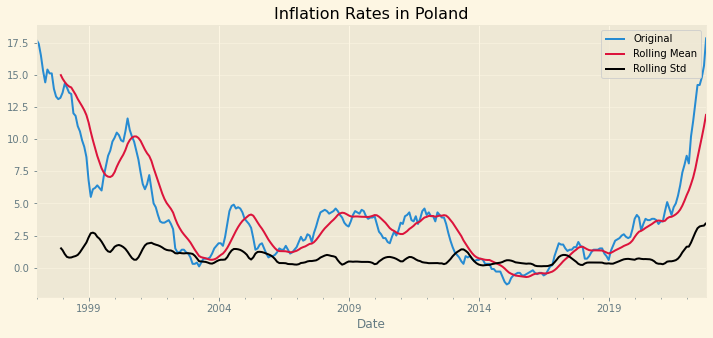

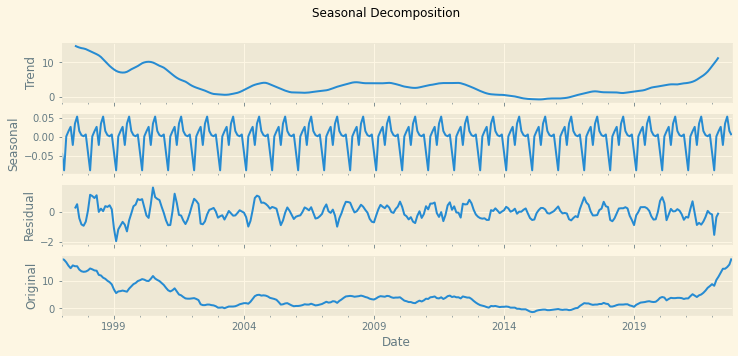

In [2]:
# visualize target data
def plot_time_series(series):
    mean_rolling = series.rolling(window=12).mean()
    std_rolling = series.rolling(window=12).std()
    
    # plot inflation rates
    series.plot(figsize=(12, 5), label='Original')
    mean_rolling.plot(color='crimson', label='Rolling Mean')
    std_rolling.plot(color='black', label='Rolling Std')
    plt.title('Inflation Rates in Poland')
    plt.grid(axis='y', alpha=0.5)
    plt.legend()
    plt.show()
    
    from statsmodels.tsa.seasonal import seasonal_decompose
    
    # plot decomposition components
    decomp = seasonal_decompose(series, model='additive')
    fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12, 5))
    fig.suptitle('Seasonal Decomposition')
    
    decomp.trend.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Trend')
    
    decomp.seasonal.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Seasonal')
    
    decomp.resid.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Residual')
    
    decomp.observed.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Original')
    plt.show()

plot_time_series(df['Rate'])

* Inflation in Poland has lately an overall upward trend.
* The dataset does not contain outliers.
* We can spot negative values (deflation) from 2014 to 2017.
* There are no familiar patterns within the data. The data looks non-stationary.

For next step, we will implement the Augmented Dickey-Fuller unit root test for data stationarity lookup. We would like to see the p-value of the test be smaller than 0.05 because this means the residuals for our time series model are independent. We also except the ADF result to be less than 5% of critical value - in other words with 95% confidence. This is often an assumption made when creating a SARIMA model.

In [3]:
# ADF statistical test
def adf_test(series):
    from statsmodels.tsa.stattools import adfuller
    
    result = adfuller(series, regression='c', autolag='AIC')
    print('======= Augmented Dickey-Fuller Test Results =======\n')
    print('1. ADF Test Statistic: ', result[0])
    print('2. P-value: ', result[1])
    print('3. Used Lags: ', result[2])
    print('4. Used Observations: ', result[3])
    print('5. Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
    
    critical_value = result[4]['5%']
    if (result[1] <= 0.05) and (result[0] < critical_value):
        print('\nStrong evidence against the null hypothesis (H0), reject the null hypothesis.\
        Data has no unit root and is stationary.')
    else:
        print('\nWeak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.')
    return

# run function
adf_test(df['Rate'])

======= Augmented Dickey-Fuller Test Results =======

1. ADF Test Statistic:  -1.7438534873303844
2. P-value:  0.40867112820385
3. Used Lags:  13
4. Used Observations:  296
5. Critical Values:
	1%: -3.452636878592149
	5%: -2.8713543954331433
	10%: -2.5719993576515705

Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.


The statistical test exhibits p-value = 0.4087 is greater than 0.05 and the data is non-stationary. We need to perform data transformation or adjusting to make the data more stationary. This action will optimize model validation.

### 2. Stationarizing Series

The p-value should be as small as possible. Some examples of series transformation include:
* logarithm,
* power transformations (Box-Cox, Yeo-Johnson, etc.),
* differencing (seasonal, n-th order differencing).

Power transformations are parametric and make data more Gaussian-like (normalized). Differencing are the most common used techniques for autoregressive modelling. Plotting ACF and PACF graphs can help us choose the best transformation by observing patterns and lags. They are also useful for determining the the ranges of components in the orders.

In [4]:
# perform data transformation
# series: must be a pandas dataframe
def series_transformation(series):
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from statsmodels.tsa.stattools import adfuller
    
    # 1st plot - data after transformation
    fig = plt.figure(figsize=(16, 4))
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.set_title('Transformed Series')
    ax1.plot(series)
    ax1.plot(series.rolling(window=12).mean(), color='crimson')
    ax1.plot(series.rolling(window=12).std(), color='black')
    
    # 2nd plot - partial autocorrelation plot
    ax2 = fig.add_subplot(1, 3, 2)
    plot_acf(series.dropna(), ax=ax2, lags=50, title='Autocorrelation')
    # plot 95% confidence intervals
    plt.axhline(y=-1.96/np.sqrt(len(series)), linestyle= '--', color= 'gray')
    plt.axhline(y=1.96/np.sqrt(len(series)), linestyle= '--', color= 'gray')
    plt.xlabel('lags')
    
    # 3rd plot - partial autocorrelation plot
    ax3 = fig.add_subplot(1, 3, 3)
    plot_pacf(series.dropna(), ax=ax3, lags=50, title='Partial Autocorrelation')
    plt.axhline(y=-1.96/np.sqrt(len(series)), linestyle= '--', color= 'gray')
    plt.axhline(y=1.96/np.sqrt(len(series)), linestyle= '--', color= 'gray')
    plt.xlabel('lags')
    plt.show()
    
    # ADF test
    result = adfuller(series.dropna(), regression='c', autolag='AIC')
    critical_value = result[4]['5%']
    if (result[1] <= 0.05) and (result[0] < critical_value):
        print('P-value = {:.6f}, the series is likely stationary.'.format(result[1]))
    else:
        print('P-value = {:.6f}, the series is likely non-stationary.'.format(result[1]))
    return

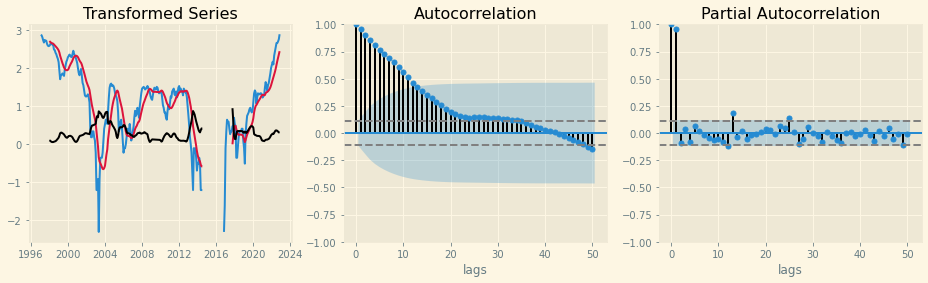

P-value = 0.133286, the series is likely non-stationary.


In [5]:
# natural logarithm transformation
series_transformation(df['Rate'].apply(np.log))

A log transformation is a bad choice. It obviously does not support negative values and we can spot that some series are missing. Other two plots display signs of a trended time series. The ACF plot (center) shows the correlations with the lags are high and positive with some decay. While the PACF plot (right) shows the partial autocorrelations have a single spike at lag 1. 

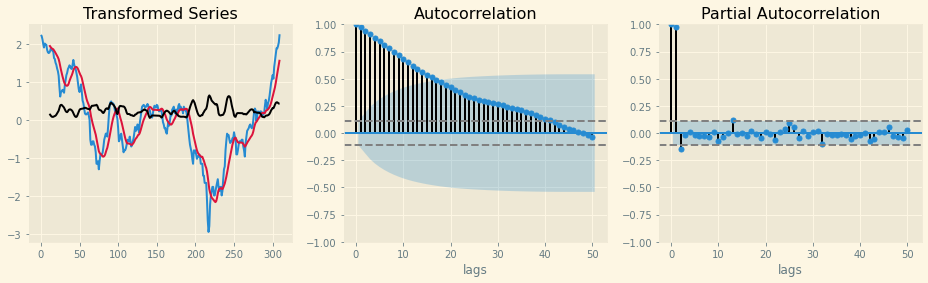

P-value = 0.301472, the series is likely non-stationary.


In [6]:
from sklearn.preprocessing import power_transform

# Yeo-Johnson power transformation
series_transformation(pd.DataFrame(power_transform(df[0:], method='yeo-johnson', standardize=True)))

The Yeo-Johnson transformation did not work enough for this dataset and p-value is still too high. The ACF graph shows strong trend and gradual decay. The insights for PACF are similar as in previous step.

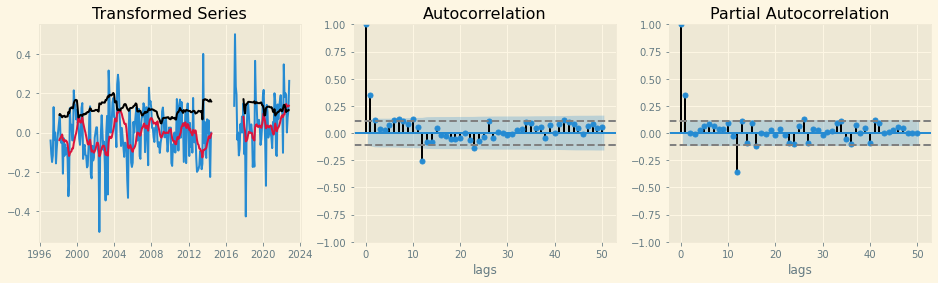

P-value = 0.003148, the series is likely stationary.


In [7]:
# combine square root and differencing
series_transformation(np.sqrt(df).diff())

Similarly as the log transformation, the square root does not support negative values and series are missing. Otherwise, it could be accepted.

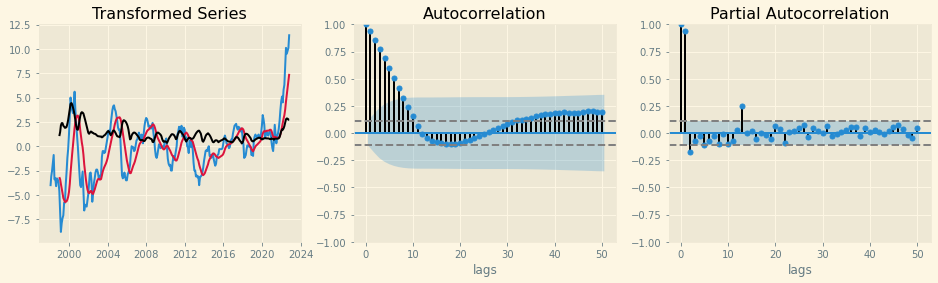

P-value = 0.393813, the series is likely non-stationary.


In [8]:
# seasonal difference
series_transformation(df - df.shift(12))

The threshold value is significantly higher then excepted. There are still visible trends in time series.

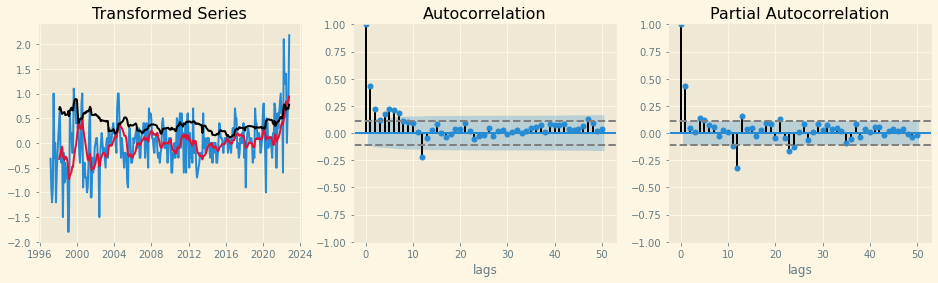

P-value = 0.048571, the series is likely stationary.


In [9]:
# first difference
series_transformation(df.diff())

The first difference time series shows less trend anymore. It looks to be more stationary. We will try further differencing.

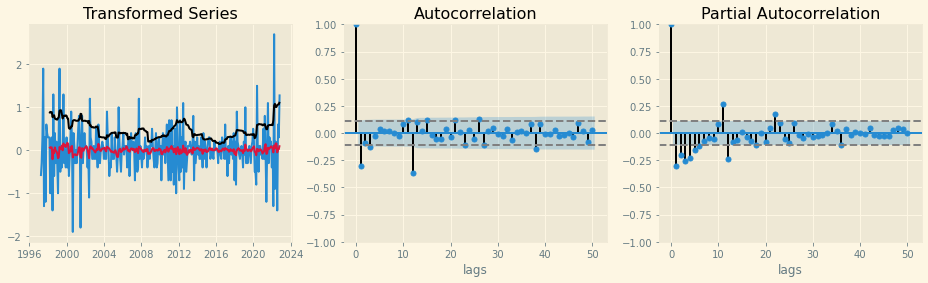

P-value = 0.000000, the series is likely stationary.


In [10]:
# second difference
series_transformation(df.diff().diff())

The second difference time series doesn’t show a strong trend anymore. The first lag autocorrelation is negative and the ACF plot is patternless. The series likely does not need a higher order of differencing. The first lag autocorrelation did not reach -0.5 and the series should not be over-differenced. Implementing another differencing order will increase the standard deviation and series will over-difference, which can result in additional complexity.

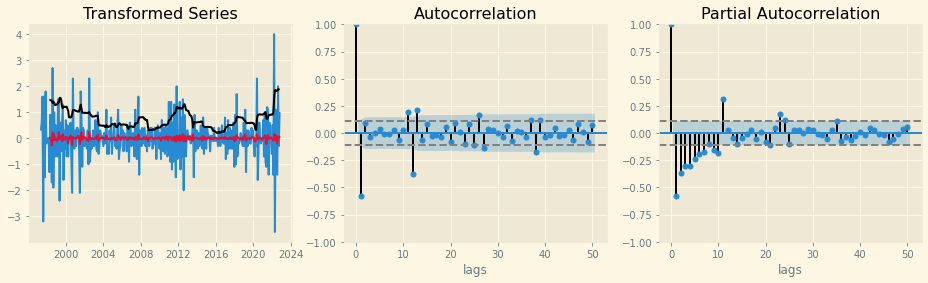

P-value = 0.000000, the series is likely stationary.


In [11]:
# third difference
series_transformation(df.diff().diff().diff())

This time we might spot over-differencing. The first lag autocorrelation reached below -0.5. The number of negative lags in PACF keeps increasing with each order. The standard deviation increased. These are all signs of over-differencing. The <code>d</code> component in trend order will be likely 2.

### 3. Find Optimal SARIMA Configuration

To forecast future rates, we will implement the SARIMA algorithm from <code>statsmodels</code> library which is an extension of the ARIMA. This model explicitly supports univariate time series data with an additional seasonal component.

The SARIMA contains main hyperparameters for <code>(p, d, q)</code> trend order and <code>(P, D, Q, m)</code> seasonality order. The <code>m</code> in the seasonality order indicates the periodicity, i.e. the number of periods in season, such as 4 for quarterly data, 12 for monthly data, 24 for hourly or 365 for daily data. In this case <code>m</code> will obviously be equal 12.

We will develop a function checking scores for each possible SARIMA orders in a grid search approach. The best performance and goodness of fit will be determined by the AIC (Akaike Information Critera). It is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. AIC can only be used to compare ARIMA models with the same orders of differencing. For ARIMAs with different orders of differencing, RMSE can be used for model comparison.

In [12]:
# find best orders and evaluate each combination for SARIMAX model
def find_optimal_orders(series, verbose=True):
    # filter out harmless warnings
    from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
    warnings.simplefilter('ignore', (ConvergenceWarning, ValueWarning))
    
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    
    ######### list of possible combinations
    order_list = []
    for p in range(0, 3):
            for d in range(0, 3):
                for q in range(0, 3):
                    order_list.append((p, d, q))
    
    ######### initialize variables
    m = 12
    trend_pdq = order_list
    seasonal_pdq = [(x[0], x[1], x[2], m) for x in order_list]
    min_aic = float('inf')
    best_params = {'order': None, 'seasonal_order': None}
    
    ######### loop through every possible configuration and print results
    print('Expected Fits: {}'.format(len(trend_pdq) * len(trend_pdq)))
    print('========== SARIMAX Results ==========\n')
    count = 0
    for param in trend_pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(endog=series, order=param, seasonal_order=param_seasonal, freq='M', exog=None,
                                enforce_stationarity=False, enforce_invertibility=False)
                model_fit = model.fit()
                
                if verbose:
                    count += 1
                    print('{}. SARIMAX{}{}[{}],\tAIC = {:.6f},\tBIC = {:.6f}'.format(count, param,
                                                        param_seasonal[:-1], m, model_fit.aic, model_fit.bic))
                    
                if model_fit.aic < min_aic:
                    min_aic = model_fit.aic
                    best_params['order'] = param
                    best_params['seasonal_order'] = param_seasonal
                    line = count
            except:
                print('Error while fitting model')
                continue
    print('\nBest order: {}{}[{}] with AIC = {:.6f} at line {}'.format(best_params['order'],
                                                             best_params['seasonal_order'][:-1], m, min_aic, line))

In [13]:
# display results
find_optimal_orders(df['Rate'], verbose=True)

Expected Fits: 729
========== SARIMAX Results ==========

1. SARIMAX(0, 0, 0)(0, 0, 0)[12],	AIC = 1954.008468,	BIC = 1957.741809
2. SARIMAX(0, 0, 0)(0, 0, 1)[12],	AIC = 1660.195211,	BIC = 1667.582675
3. SARIMAX(0, 0, 0)(0, 0, 2)[12],	AIC = 1444.231021,	BIC = 1455.188488
4. SARIMAX(0, 0, 0)(0, 1, 0)[12],	AIC = 1476.871203,	BIC = 1480.564936
5. SARIMAX(0, 0, 0)(0, 1, 1)[12],	AIC = 1411.752072,	BIC = 1419.057050
6. SARIMAX(0, 0, 0)(0, 1, 2)[12],	AIC = 1320.046975,	BIC = 1330.875390
7. SARIMAX(0, 0, 0)(0, 2, 0)[12],	AIC = 1574.544799,	BIC = 1578.197289
8. SARIMAX(0, 0, 0)(0, 2, 1)[12],	AIC = 1367.460221,	BIC = 1374.679165
9. SARIMAX(0, 0, 0)(0, 2, 2)[12],	AIC = 1236.652523,	BIC = 1247.346085
10. SARIMAX(0, 0, 0)(1, 0, 0)[12],	AIC = 1441.344220,	BIC = 1448.738407
11. SARIMAX(0, 0, 0)(1, 0, 1)[12],	AIC = 1440.062830,	BIC = 1451.144026
12. SARIMAX(0, 0, 0)(1, 0, 2)[12],	AIC = 1390.929491,	BIC = 1405.539448
13. SARIMAX(0, 0, 0)(1, 1, 0)[12],	AIC = 1421.399824,	BIC = 1428.711807
14. SARIMAX(0, 

116. SARIMAX(0, 1, 1)(0, 2, 1)[12],	AIC = 570.242676,	BIC = 581.049033
117. SARIMAX(0, 1, 1)(0, 2, 2)[12],	AIC = 374.638202,	BIC = 388.865514
118. SARIMAX(0, 1, 1)(1, 0, 0)[12],	AIC = 346.854275,	BIC = 357.935471
119. SARIMAX(0, 1, 1)(1, 0, 1)[12],	AIC = 343.579591,	BIC = 358.327493
120. SARIMAX(0, 1, 1)(1, 0, 2)[12],	AIC = 301.981955,	BIC = 320.209189
121. SARIMAX(0, 1, 1)(1, 1, 0)[12],	AIC = 455.699439,	BIC = 466.656906
122. SARIMAX(0, 1, 1)(1, 1, 1)[12],	AIC = 354.767966,	BIC = 369.349754
123. SARIMAX(0, 1, 1)(1, 1, 2)[12],	AIC = 330.260313,	BIC = 348.270907
124. SARIMAX(0, 1, 1)(1, 2, 0)[12],	AIC = 653.037662,	BIC = 663.866077
125. SARIMAX(0, 1, 1)(1, 2, 1)[12],	AIC = 466.073768,	BIC = 480.482244
126. SARIMAX(0, 1, 1)(1, 2, 2)[12],	AIC = 363.552420,	BIC = 381.336560
127. SARIMAX(0, 1, 1)(2, 0, 0)[12],	AIC = 312.976921,	BIC = 327.586878
128. SARIMAX(0, 1, 1)(2, 0, 1)[12],	AIC = 313.465316,	BIC = 331.727762
129. SARIMAX(0, 1, 1)(2, 0, 2)[12],	AIC = 301.525081,	BIC = 323.397763
130. S

232. SARIMAX(0, 2, 2)(1, 2, 0)[12],	AIC = 658.449475,	BIC = 672.872683
233. SARIMAX(0, 2, 2)(1, 2, 1)[12],	AIC = 464.788704,	BIC = 482.762261
234. SARIMAX(0, 2, 2)(1, 2, 2)[12],	AIC = 338.486789,	BIC = 359.781245
235. SARIMAX(0, 2, 2)(2, 0, 0)[12],	AIC = 259.896449,	BIC = 278.141320
236. SARIMAX(0, 2, 2)(2, 0, 1)[12],	AIC = 257.713001,	BIC = 279.606846
237. SARIMAX(0, 2, 2)(2, 0, 2)[12],	AIC = 240.725550,	BIC = 266.194032
238. SARIMAX(0, 2, 2)(2, 1, 0)[12],	AIC = 353.740868,	BIC = 371.769879
239. SARIMAX(0, 2, 2)(2, 1, 1)[12],	AIC = 292.148880,	BIC = 313.783692
240. SARIMAX(0, 2, 2)(2, 1, 2)[12],	AIC = 289.038357,	BIC = 314.201337
241. SARIMAX(0, 2, 2)(2, 2, 0)[12],	AIC = 514.078859,	BIC = 531.882267
242. SARIMAX(0, 2, 2)(2, 2, 1)[12],	AIC = 387.177591,	BIC = 408.541681
243. SARIMAX(0, 2, 2)(2, 2, 2)[12],	AIC = 346.546037,	BIC = 371.389570
244. SARIMAX(1, 0, 0)(0, 0, 0)[12],	AIC = 458.721796,	BIC = 466.188479
245. SARIMAX(1, 0, 0)(0, 0, 1)[12],	AIC = 403.318737,	BIC = 414.399933
246. S

348. SARIMAX(1, 1, 0)(2, 1, 2)[12],	AIC = 311.071975,	BIC = 332.706788
349. SARIMAX(1, 1, 0)(2, 2, 0)[12],	AIC = 504.358565,	BIC = 518.601292
350. SARIMAX(1, 1, 0)(2, 2, 1)[12],	AIC = 381.241729,	BIC = 399.045137
351. SARIMAX(1, 1, 0)(2, 2, 2)[12],	AIC = 361.267561,	BIC = 382.631650
352. SARIMAX(1, 1, 1)(0, 0, 0)[12],	AIC = 388.381861,	BIC = 399.562405
353. SARIMAX(1, 1, 1)(0, 0, 1)[12],	AIC = 293.217561,	BIC = 307.965463
354. SARIMAX(1, 1, 1)(0, 0, 2)[12],	AIC = 248.375286,	BIC = 266.602520
355. SARIMAX(1, 1, 1)(0, 1, 0)[12],	AIC = 632.241687,	BIC = 643.302613
356. SARIMAX(1, 1, 1)(0, 1, 1)[12],	AIC = 358.376764,	BIC = 372.958552
357. SARIMAX(1, 1, 1)(0, 1, 2)[12],	AIC = 302.486351,	BIC = 320.496946
358. SARIMAX(1, 1, 1)(0, 2, 0)[12],	AIC = 919.148587,	BIC = 930.084928
359. SARIMAX(1, 1, 1)(0, 2, 1)[12],	AIC = 570.734675,	BIC = 585.143150
360. SARIMAX(1, 1, 1)(0, 2, 2)[12],	AIC = 363.885834,	BIC = 381.669974
361. SARIMAX(1, 1, 1)(1, 0, 0)[12],	AIC = 315.619957,	BIC = 330.381395
362. S

464. SARIMAX(1, 2, 2)(0, 1, 1)[12],	AIC = 348.027601,	BIC = 366.219374
465. SARIMAX(1, 2, 2)(0, 1, 2)[12],	AIC = 298.483865,	BIC = 320.052133
466. SARIMAX(1, 2, 2)(0, 2, 0)[12],	AIC = 922.040679,	BIC = 936.594098
467. SARIMAX(1, 2, 2)(0, 2, 1)[12],	AIC = 577.062075,	BIC = 595.035632
468. SARIMAX(1, 2, 2)(0, 2, 2)[12],	AIC = 355.016188,	BIC = 376.310644
469. SARIMAX(1, 2, 2)(1, 0, 0)[12],	AIC = 296.976232,	BIC = 315.411108
470. SARIMAX(1, 2, 2)(1, 0, 1)[12],	AIC = 288.967236,	BIC = 311.048272
471. SARIMAX(1, 2, 2)(1, 0, 2)[12],	AIC = 240.404816,	BIC = 265.873299
472. SARIMAX(1, 2, 2)(1, 1, 0)[12],	AIC = 435.979692,	BIC = 454.206926
473. SARIMAX(1, 2, 2)(1, 1, 1)[12],	AIC = 319.479038,	BIC = 341.309166
474. SARIMAX(1, 2, 2)(1, 1, 2)[12],	AIC = 298.607971,	BIC = 323.770951
475. SARIMAX(1, 2, 2)(1, 2, 0)[12],	AIC = 646.805906,	BIC = 664.816500
476. SARIMAX(1, 2, 2)(1, 2, 1)[12],	AIC = 466.398985,	BIC = 487.967254
477. SARIMAX(1, 2, 2)(1, 2, 2)[12],	AIC = 340.266919,	BIC = 365.110451
478. S

580. SARIMAX(2, 1, 0)(1, 1, 0)[12],	AIC = 432.082216,	BIC = 446.664004
581. SARIMAX(2, 1, 0)(1, 1, 1)[12],	AIC = 333.191766,	BIC = 351.419000
582. SARIMAX(2, 1, 0)(1, 1, 2)[12],	AIC = 314.425781,	BIC = 336.060593
583. SARIMAX(2, 1, 0)(1, 2, 0)[12],	AIC = 640.410661,	BIC = 654.819137
584. SARIMAX(2, 1, 0)(1, 2, 1)[12],	AIC = 462.141980,	BIC = 480.152574
585. SARIMAX(2, 1, 0)(1, 2, 2)[12],	AIC = 354.754975,	BIC = 376.119065
586. SARIMAX(2, 1, 0)(2, 0, 0)[12],	AIC = 271.467991,	BIC = 289.695225
587. SARIMAX(2, 1, 0)(2, 0, 1)[12],	AIC = 261.684227,	BIC = 283.556908
588. SARIMAX(2, 1, 0)(2, 0, 2)[12],	AIC = 263.671824,	BIC = 289.189952
589. SARIMAX(2, 1, 0)(2, 1, 0)[12],	AIC = 353.757078,	BIC = 371.767672
590. SARIMAX(2, 1, 0)(2, 1, 1)[12],	AIC = 304.643452,	BIC = 326.256165
591. SARIMAX(2, 1, 0)(2, 1, 2)[12],	AIC = 306.495233,	BIC = 331.710064
592. SARIMAX(2, 1, 0)(2, 2, 0)[12],	AIC = 502.011902,	BIC = 519.796042
593. SARIMAX(2, 1, 0)(2, 2, 1)[12],	AIC = 381.831938,	BIC = 403.172906
594. S

696. SARIMAX(2, 2, 1)(2, 0, 2)[12],	AIC = 242.112109,	BIC = 271.247366
697. SARIMAX(2, 2, 1)(2, 1, 0)[12],	AIC = 353.599277,	BIC = 375.189809
698. SARIMAX(2, 2, 1)(2, 1, 1)[12],	AIC = 289.265494,	BIC = 314.454448
699. SARIMAX(2, 2, 1)(2, 1, 2)[12],	AIC = 290.922613,	BIC = 319.709989
700. SARIMAX(2, 2, 1)(2, 2, 0)[12],	AIC = 508.872656,	BIC = 530.190414
701. SARIMAX(2, 2, 1)(2, 2, 1)[12],	AIC = 383.357482,	BIC = 408.228199
702. SARIMAX(2, 2, 1)(2, 2, 2)[12],	AIC = 350.349543,	BIC = 378.773220
703. SARIMAX(2, 2, 2)(0, 0, 0)[12],	AIC = 383.692514,	BIC = 402.294073
704. SARIMAX(2, 2, 2)(0, 0, 1)[12],	AIC = 287.489475,	BIC = 309.570511
705. SARIMAX(2, 2, 2)(0, 0, 2)[12],	AIC = 240.546975,	BIC = 266.015458
706. SARIMAX(2, 2, 2)(0, 1, 0)[12],	AIC = 638.829851,	BIC = 657.230714
707. SARIMAX(2, 2, 2)(0, 1, 1)[12],	AIC = 352.325726,	BIC = 374.155854
708. SARIMAX(2, 2, 2)(0, 1, 2)[12],	AIC = 295.043170,	BIC = 320.206149
709. SARIMAX(2, 2, 2)(0, 2, 0)[12],	AIC = 923.984478,	BIC = 942.176251
710. S

The function returned the optimal hyperparameters to implement in the final model.

### 4. Developing SARIMA Model

We will start by forecasting and visualizing the future inflation rates. Next step, we will plot diagnostics and calculate some evaluation scores to judge the performance of our model.

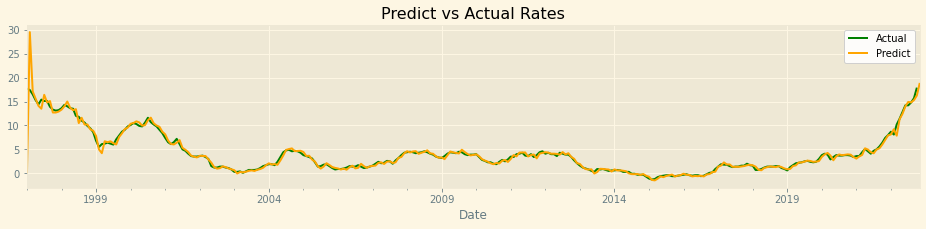

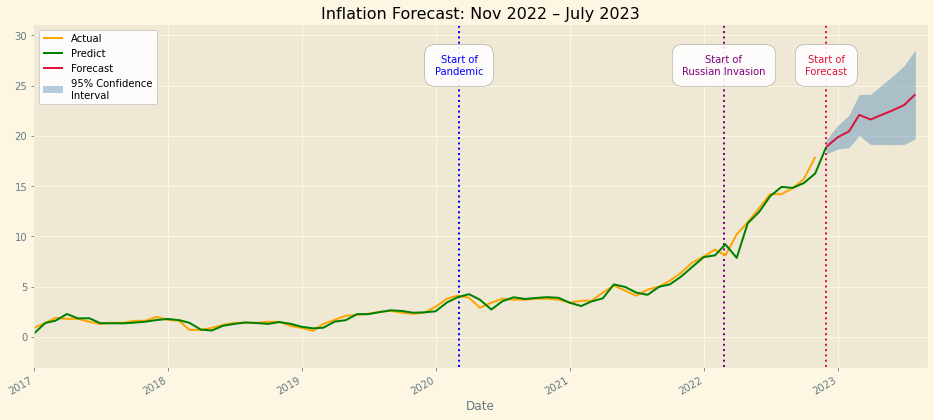

,Forecast [%]
2022-11-30,18.9
2022-12-31,19.8
2023-01-31,20.4
2023-02-28,22.1
2023-03-31,21.6
2023-04-30,22.1
2023-05-31,22.5
2023-06-30,23.0
2023-07-31,24.1


In [14]:
# SARIMA model visualization
def forecast_SARIMA(series, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0), exog=None):
    from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
    warnings.simplefilter('ignore', (ConvergenceWarning, ValueWarning))
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    
    # develop model
    model = SARIMAX(endog=series, order=order, seasonal_order=seasonal_order, freq='M', exog=exog,
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit()
    
    # predictions
    yhat = model_fit.predict(start=0, end=len(series), typ='levels', dynamic=False).rename('Predict')

    # forecast and confidence intervals 95%
    conf_int = model_fit.get_forecast(steps=9).summary_frame()
    
    # extract index list
    def index_list():
        conf_interval = conf_int.reset_index()
        return conf_interval['index'].to_list()

    indx_list = index_list()
    
    # 1st plot - actual vs predict rates
    series.plot(legend=True, label='Actual', figsize=(16, 3), color='green')
    yhat.plot(legend=True, color='orange')
    plt.title('Predict vs Actual Rates')
    plt.legend(facecolor='white', framealpha=0.9)
    plt.show()
    
    # list of events to plot
    event_list = [(pd.to_datetime('2020-03-04'), 'Start of\nPandemic', 'blue'),
                  (pd.to_datetime('2022-11-30'), 'Start of\nForecast', 'crimson'),
                  (pd.to_datetime('2022-02-24'), 'Start of\nRussian Invasion', 'purple')]
    
    # plot events
    for date_point, label, clr in event_list:
        plt.axvline(x=date_point, color=clr, linestyle=':')
        plt.text(x=date_point, y=27, s=label, horizontalalignment='center', verticalalignment='center',
                 color=clr, bbox=dict(facecolor='white', alpha=0.9, boxstyle='round, pad=1', linewidth=0.2))

    # 2nd plot - forecasting results
    series.plot(legend=True, label='Actual', figsize=(16, 7), color='orange')
    yhat.plot(legend=True, color='green')
    conf_int['mean'].plot(legend=True, label='Forecast', color='crimson')
    plt.fill_between(x=indx_list, y1=conf_int['mean_ci_upper'], y2=conf_int['mean_ci_lower'], color='steelblue',
                     alpha=0.4, label='95% Confidence\nInterval', linewidth=0)                
    plt.xlim(['2017', '2023-09'])
    plt.title('Inflation Forecast: Nov 2022 – July 2023')
    plt.legend(loc='upper left', facecolor='white', framealpha=0.9)
    plt.show()
    
    # display forecasted rates
    return pd.DataFrame(round(conf_int['mean'], 1)).rename({'mean': 'Forecast [%]'}, axis=1)

# plot SARIMA results
forecast_SARIMA(series=df['Rate'], order=(0, 2, 2), seasonal_order=(0, 0, 2, 12))

* The predict spline is fitted to the actual with high accuracy. There are high differences only at the beginning of time series.
* From the beginning of the COVID-19 pandemic in Poland we can spot gradual inflation growth. From around July 2021, the change starts to be expotential and growths very rapidly.
* Contrary to what the ruling party says, the Russian invasion of Ukraine did not affect Polish inflation significantly. There are no visible changes in trend.

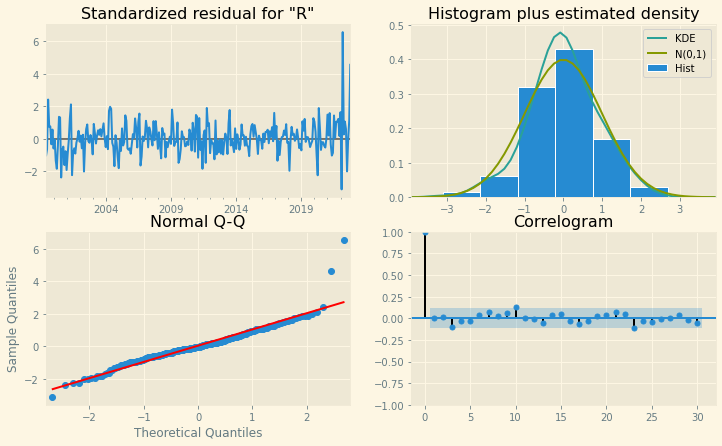

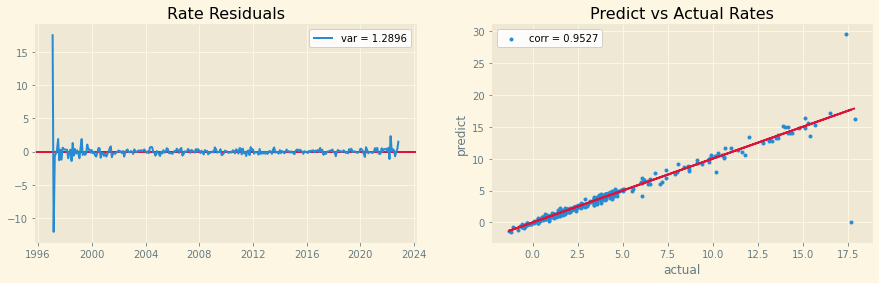

Metric,AIC,BIC,HQIC,RMSE,MAE,MAPE
,237.20807,255.399843,244.503993,1.289995,0.38878,0.156649


In [15]:
# SARIMA model evaluation
def evaluate_SARIMA(series, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0), exog=None):
    from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
    warnings.simplefilter('ignore', (ConvergenceWarning, ValueWarning))
    from statsmodels.tsa.statespace.sarimax import SARIMAX

    # develop model
    model = SARIMAX(endog=series, order=order, seasonal_order=seasonal_order, freq='M', exog=None,
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit()
    
    # predictions
    yhat = model_fit.predict(start=0, end=len(series), typ='levels', dynamic=False).rename('Predict')
    
    ######### evaluation scores
    rmse = np.mean((series - yhat[:-1])**2)**0.5
    mae = np.mean(np.abs(series - yhat[:-1]))
    mape = np.mean(np.abs(series - yhat[:-1])/np.abs(series))
    var = np.std(model_fit.resid.values)
    corr = np.corrcoef(series, yhat[:-1])[0, 1]
    
    metric_list = ['AIC', 'BIC', 'HQIC', 'RMSE', 'MAE', 'MAPE']
    value_list = [model_fit.aic, model_fit.bic, model_fit.hqic, rmse, mae, mape]
 
    # 1st plot - diagnostics
    model_fit.plot_diagnostics(lags=30, figsize=(12, 7))
    plt.show()
    
    # 2nd plot - residuals
    fig = plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.axhline(0, color='crimson')
    plt.plot(model_fit.resid, label='var = {:.4f}'.format(var))
    plt.title('Rate Residuals')
    plt.legend(facecolor='white', framealpha=0.9)
    
    # 3rd plot - actual vs predict rates
    plt.subplot(1, 2, 2)
    plt.plot(df['Rate'], df['Rate'], color='crimson')
    plt.scatter(x=df['Rate'], y=yhat[:-1], marker='.', label='corr = {:.4f}'.format(corr))
    plt.title('Predict vs Actual Rates')
    plt.xlabel('actual')
    plt.ylabel('predict')
    plt.legend(facecolor='white', framealpha=0.9)
    plt.show()

    # display evaluation scores
    return pd.DataFrame(zip(metric_list, value_list), columns=['Metric', '']).set_index('Metric').T

# model evaluation
evaluate_SARIMA(series=df['Rate'], order=(0, 2, 2), seasonal_order=(0, 0, 2, 12))

**Diagnostics plots**
* The standardized residuals appear to be white noise.
* The residuals on the histogram follow quite close the standard normal distribution with positive skewness.
* The Q–Q plot (quantile-quantile plot) displays marker deviation upon the second quartiles (median values). In general, the markers are aligned quite good on the red line.
* The correlogram shows no significant autocorrelations for residual errors. Any autocorrelation would suggest that there is some pattern in the residual which are not explained in the model.

**Bottom plots**
* The residuals are plotted chronologically without any transformations. They seem to fluctuate around a mean of zero. Again, we can see highest residuals at the beginning of time serires. The variance describes the dispersion, how far the set of residuals is spread out from their average value.
* Bottom right plot compares predicted rates with actual values. There is very strong correlation between these two features meaning that the inflation rates were predicted accurately.

### 5. Conclusion

We forecasted inflation rates with autoregressive modelling. As accepted, inflation in Poland will continue to increase and by the end of this year it may reach around 20%. We should still expect higher prices of goods and services over the next few months.

Using the SARIMA model, we can forecast and analyze a time series using the series past inflation rates. It only requires the prior (historical) data of a time series to generalize the forecast which is a great advantage. No additional coefficients are needed to include for the validation process.

Owing to classical statistics and purely statistical methodology, autoregressive models are considered relic but are easier to understand. They require lots of prior knowledge to use them successfully. They also involve lots of hyperparameter tuning, polishing, and computational to make them accurate. Therefore, they are insufficient for many modern applications and give way to deep learning. We need to keep in mind that the SARIMA method performances great for short term forecasts. The model is used primarily for illustrative purposes and to know what to expect in the near future. Still, a SARIMA model can therefore be an attractive alternative.

**Further Development**

The forecasting algorithm can be enriched by adding exogenous (external) variables - determined outside the model and imposed on the model. Including external data might make the model respond much quicker to its effect than if it relies on the influence of lagging terms. We can also extend the ranges of components in orders or include other parameters for the stepwise search stage.